### Import packages

In [1]:
library(data.table)
library(Matrix)
library(proxy)
library(Rtsne)
library(densityClust)
library(data.table)
library(irlba)
library(umap)
library(ggplot2)


Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix



### Preprocess

`bsub < count_reads_peaks_erisone.sh`

In [2]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 2034

In [3]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [4]:
dim(datafr)

[1] 491437   2034

In [5]:
df_regions = read.csv("../../input/GSE96769_PeakFile_20160207.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [6]:
dim(df_regions)

[1] 491437     14

In [7]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [8]:
head(peaknames)

[1] "chr1_10279_10779"   "chr1_13252_13752"   "chr1_16019_16519"  
[4] "chr1_29026_29526"   "chr1_96364_96864"   "chr1_115440_115940"

In [9]:
head(sapply(strsplit(files,'\\.'),'[', 1))

[1] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14"
[3] "BM1077-CLP-Frozen-160106-2"  "BM1077-CLP-Frozen-160106-21"
[5] "BM1077-CLP-Frozen-160106-27" "BM1077-CLP-Frozen-160106-3"

In [10]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 1)
rownames(datafr) = peaknames

In [11]:
head(datafr)

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27,BM1077-CLP-Frozen-160106-3,BM1077-CLP-Frozen-160106-36,BM1077-CLP-Frozen-160106-42,BM1077-CLP-Frozen-160106-44,BM1077-CLP-Frozen-160106-50,⋯,singles-PB1022-mono-160128-81,singles-PB1022-mono-160128-82,singles-PB1022-mono-160128-83,singles-PB1022-mono-160128-84,singles-PB1022-mono-160128-85,singles-PB1022-mono-160128-86,singles-PB1022-mono-160128-89,singles-PB1022-mono-160128-90,singles-PB1022-mono-160128-95,singles-PB1022-mono-160128-96
chr1_10279_10779,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_13252_13752,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_16019_16519,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_29026_29526,0,0,0,0,0,0,0,0,2,0,⋯,0,0,2,0,2,3,0,0,0,0
chr1_96364_96864,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,2,0,0
chr1_115440_115940,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:
dim(datafr)

[1] 491437   2034

In [13]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [14]:
elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

### Obtain Feature Matrix

In [15]:
start_time <- Sys.time()

In [16]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [17]:
binary_mat = as.matrix((datafr > 0) + 0)
binary_mat = Matrix(binary_mat, sparse = TRUE) 

In [18]:
binary_mat[1:3,1:3]

3 x 3 sparse Matrix of class "dgCMatrix"
                 BM1077-CLP-Frozen-160106-13 BM1077-CLP-Frozen-160106-14
chr1_10279_10779                           .                           .
chr1_13252_13752                           .                           .
chr1_16019_16519                           .                           .
                 BM1077-CLP-Frozen-160106-2
chr1_10279_10779                          .
chr1_13252_13752                          .
chr1_16019_16519                          .

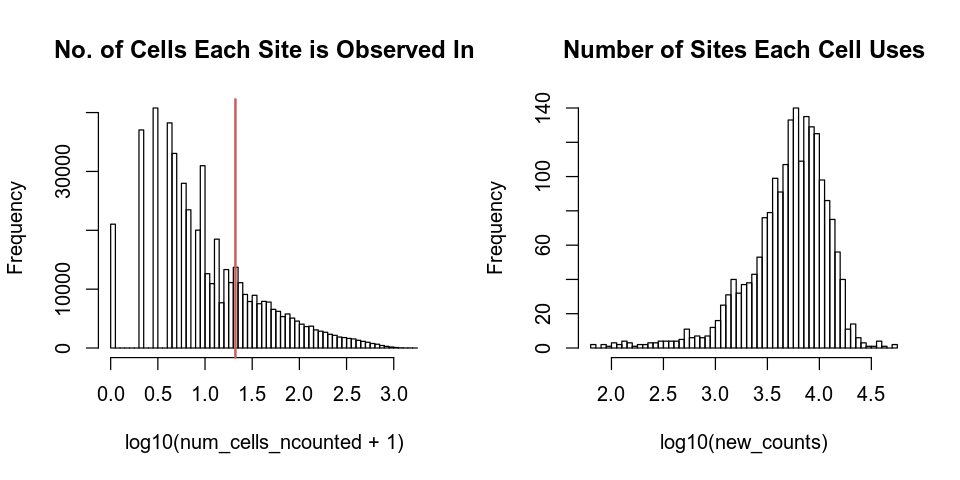

In [19]:
num_cells_ncounted = rowSums(binary_mat)
ncounts = binary_mat[num_cells_ncounted >= dim(binary_mat)[2]*0.01,]
new_counts = colSums(ncounts)
# ncounts = ncounts[,new_counts >= quantile(new_counts,probs=0.1)]
ncounts = ncounts[rowSums(ncounts) > 0,]

options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
hist(log10(num_cells_ncounted+1),main="No. of Cells Each Site is Observed In",breaks=50)
abline(v=log10(min(num_cells_ncounted[num_cells_ncounted >= dim(binary_mat)[2]*0.01])),lwd=2,col="indianred")
hist(log10(new_counts),main="Number of Sites Each Cell Uses",breaks=50)
# abline(v=log10(quantile(new_counts,probs=0.1)),lwd=2,col="indianred")

In [20]:
dim(ncounts)

[1] 135202   2034

In [21]:
sexsites = c(grep("chrY",rownames(ncounts)),grep("chrX",rownames(ncounts)))
ncounts.nosex = ncounts[-sexsites,]

nfreqs = t(t(ncounts.nosex) / Matrix::colSums(ncounts.nosex))
idf = as(log(1 + ncol(ncounts.nosex) / Matrix::rowSums(ncounts.nosex)), "sparseVector")
tf_idf_counts = as(Diagonal(x=as.vector(idf)), "sparseMatrix") %*% nfreqs

In [22]:
dim(tf_idf_counts)

[1] 132110   2034

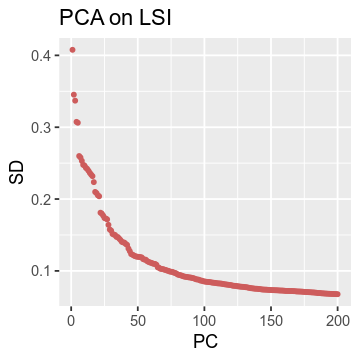

In [23]:
p_elbow_LSI <- elbow_plot(tf_idf_counts,num_pcs = 200, title = 'PCA on LSI')
p_elbow_LSI

In [24]:
set.seed(2019)
num_pcs = 150
SVDtsne = irlba(tf_idf_counts, num_pcs, num_pcs)
d_diagtsne = matrix(0, nrow=num_pcs, ncol=num_pcs)
diag(d_diagtsne) = SVDtsne$d
SVDtsne_vd = t(d_diagtsne %*% t(SVDtsne$v))

dim(SVDtsne_vd)
SVDtsne_vd[1:3,1:3]

[1] 2034  150

0.009343241,0.0005602915,-0.0007767990
0.009680649,0.0006166988,-0.0006587855
0.009723947,0.0007909515,-0.0007465030


In [25]:
end_time <- Sys.time()

In [26]:
end_time - start_time

Time difference of 2.52053 mins

In [28]:
df_out = t(SVDtsne_vd)
colnames(df_out) = colnames(datafr)
rownames(df_out) = paste('PC',1:dim(SVDtsne_vd)[2])
dim(df_out)

[1]  150 2034

In [29]:
all(colnames(df_out) == rownames(metadata))

[1] TRUE

In [30]:
saveRDS(df_out, file = '../../output/feature_matrices/FM_Cusanovich2018_buenrostro2018bulkpeaks.rds')

### Downstream Analysis

In [31]:
set.seed(0)
tsnetfidf = Rtsne(SVDtsne_vd,pca=F)

In [32]:
library(RColorBrewer)

In [33]:
plot.tsne <- function(x, labels,
         main="A tSNE visualization",n=20,
         pad=0.1, cex=0.65, pch=19, add=FALSE, legend.suffix="",
         cex.main=1, cex.legend=1) {
  qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
  col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
  layout = x
  
  xylim = range(layout)
  xylim = xylim + ((xylim[2]-xylim[1])*pad)*c(-0.5, 0.5)
  if (!add) {
    par(mar=c(0.2,0.7,1.2,0.7), ps=10)
    plot(xylim, xylim, type="n", axes=F, frame=F)
    rect(xylim[1], xylim[1], xylim[2], xylim[2], border="#aaaaaa", lwd=0.25)  
  }
  points(layout[,1], layout[,2], col=col_vector[as.integer(labels)],
         cex=cex, pch=pch)
  mtext(side=3, main, cex=cex.main)

  labels.u = unique(labels)
  legend.pos = "topright"
  legend.text = as.character(labels.u)
  if (add) {
    legend.pos = "bottomright"
    legend.text = paste(as.character(labels.u), legend.suffix)
  }
  legend(legend.pos, legend=legend.text,
         col=col_vector[as.integer(labels.u)],
         bty="n", pch=pch, cex=cex.legend)
}

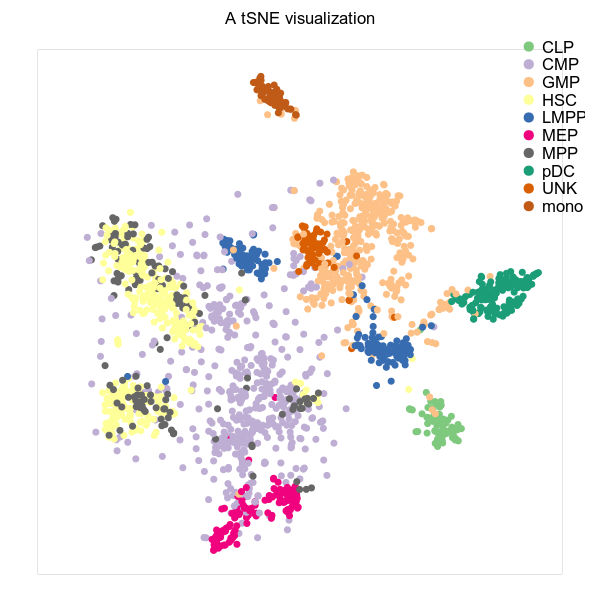

In [34]:
options(repr.plot.width=5, repr.plot.height=5)
plot.tsne(tsnetfidf$Y,as.factor(metadata[,'label']))

In [35]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_sciATAC/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-2 ggplot2_3.1.1      umap_0.2.0.0       irlba_2.3.2       
[5] densityClust_0.3   Rtsne_0.15         proxy_0.4-22       Matrix_1.2-17     
[9] data.table_1.12.2 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       compiler_3.5.1   pillar_1.3.

In [36]:
save.image(file = 'Cusanovich2018_buenrostro2018bulkpeaks.RData')